Прогнозирование временного ряда.

In [1]:
# обработка
import numpy as np
import pandas as pd

# визуализация
import matplotlib.pyplot as plt

# метрики
from sklearn.metrics import mean_squared_error
from math import sqrt

# моделирование
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [2]:
df = pd.read_csv('D:\\Work\\data\\time_series\\Train.csv')

In [3]:
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
df_train = pd.read_csv('D:\\Work\\data\\time_series\\Train.csv', nrows = 11856)
train = df_train[:10392]
test = df_train[10392:]

In [5]:
df_train.Timestamp = pd.to_datetime(df_train.Datetime,format='%d-%m-%Y %H:%M') 
df_train.index = df_train.Timestamp 
df_train = df_train.resample('D').mean()

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').mean()

test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean()

<ipython-input-5-13665c135bd4>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_train.Timestamp = pd.to_datetime(df_train.Datetime,format='%d-%m-%Y %H:%M')
<ipython-input-5-13665c135bd4>:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
<ipython-input-5-13665c135bd4>:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')


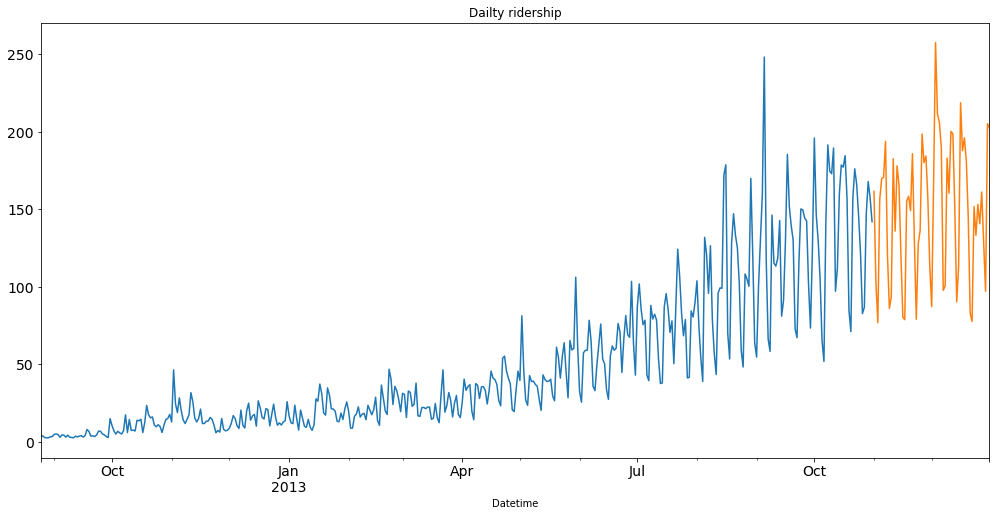

In [6]:
train['Count'].plot(figsize = (17,8), title = 'Daily ridership', fontsize = 14)
test['Count'].plot(figsize = (17,8), title = 'Dailty ridership', fontsize = 14)

Применим модель Seasonal ARIMA:

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


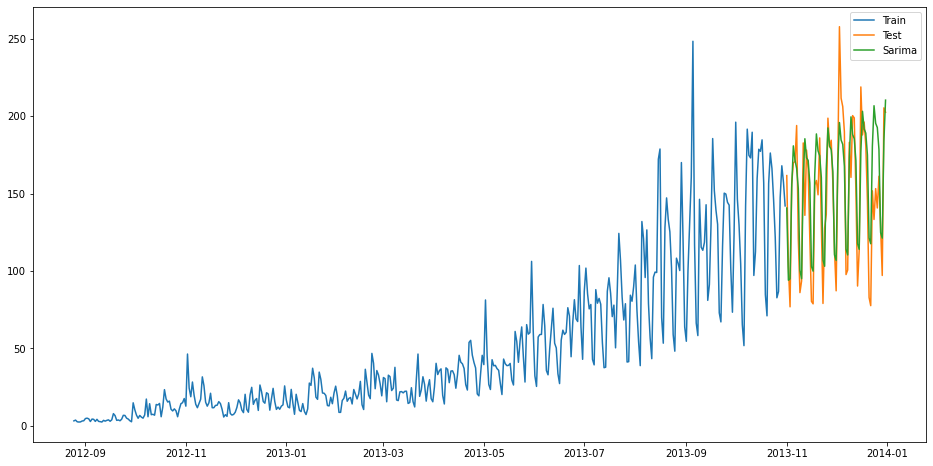

In [7]:
y_hat_sarima_avg = test.copy()
fit1 = SARIMAX(train['Count'], order=(2, 1, 4), seasonal_order=(0, 1, 1, 7)).fit()
y_hat_sarima_avg['Sarima'] = fit1.predict(start='2013-11-1', end='2013-12-31',dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_sarima_avg['Sarima'], label='Sarima')
plt.legend(loc='best')

In [8]:
rms = sqrt(mean_squared_error(test['Count'], y_hat_sarima_avg['Sarima']))
print('Sqrt RMSE:', rms) 

Sqrt RMSE: 25.99754043143406


In [9]:
y_hat_sarima_avg.to_csv('D:\\Work\\data\\time_series\\forecast.csv')